# Exploratory Data Analysis on Flights Data

___
We conduct elementary EDA and analysis on our dataset. </br>
We try to use Spark as much as possible, in line with the goals of this course. 
___

In [1]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, skewness, kurtosis
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

In [3]:
spark = SparkSession.builder.appName("flights").getOrCreate()

24/03/16 16:37:03 WARN Utils: Your hostname, Edmunds-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.5.45 instead (on interface en0)
24/03/16 16:37:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 16:37:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

## Load in Data and Perform Elementary Analysis

If running locally, the filepath may be too big to unzip to your local computer, instead use the following command

```
!unzip -p itineraries.zip itineraries.csv | head -n 10000 > itineraries.csv
```

In [5]:
# REPLACE WITH DATA FILEPATH
DATA_PATH = "../data/itineraries.csv"

In [6]:
# Load both spark and pandas versions of the dataframe
df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)
df_pd = pd.read_csv(DATA_PATH)

In [7]:
print(f"The data contains {df.count()} rows and {len(df.columns)} columns")

The data contains 9999 rows and 27 columns


In [8]:
df.columns

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'fareBasisCode',
 'travelDuration',
 'elapsedDays',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeEpochSeconds',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeEpochSeconds',
 'segmentsArrivalTimeRaw',
 'segmentsArrivalAirportCode',
 'segmentsDepartureAirportCode',
 'segmentsAirlineName',
 'segmentsAirlineCode',
 'segmentsEquipmentDescription',
 'segmentsDurationInSeconds',
 'segmentsDistance',
 'segmentsCabinCode']

In [9]:
# Too messy to use df.show() directly, lets look at it 6 columns at a time
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

for chunk in chunks(df.columns, 6):
    df.select(chunk).show()

+--------------------+----------+----------+---------------+------------------+-------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|
+--------------------+----------+----------+---------------+------------------+-------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|     LA0NX0MC|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|               BOS|     LA0NX0MC|
|98d90cbc32bfbb05c...|2022-04-16|2022-04-17|            ATL|               BOS|     LA0NX0MC|
|969a269d38eae583f...|2022-04-16|2022-04-17|            ATL|               BOS|     LA0NX0MC|
|980370cf27c89b40d...|2022-04-16|2022-04-17|            ATL|               BOS|     LA0NX0MC|
|79eda9f841e226a1e...|2022-04-16|2022-04-17|            ATL|               BOS|     VH0AUEL1|
|9335fae376c38bb61...|2022-04-16|2022-04-17|            ATL|               BOS|     V0AJZNN1|
|3904bf87f2d1daf33...|2022-04-16|2022-04-17|            ATL|

In [10]:
# look at the schema
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [11]:
# rows and columns
print(f"rows = {df.count()}, columns = {len(df.columns)}")

rows = 9999, columns = 27


In [12]:
# Select Essential Information
df.select(["legId","searchDate","flightDate","startingAirport","destinationAirport"]).show()

+--------------------+----------+----------+---------------+------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|
+--------------------+----------+----------+---------------+------------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|               BOS|
|98d90cbc32bfbb05c...|2022-04-16|2022-04-17|            ATL|               BOS|
|969a269d38eae583f...|2022-04-16|2022-04-17|            ATL|               BOS|
|980370cf27c89b40d...|2022-04-16|2022-04-17|            ATL|               BOS|
|79eda9f841e226a1e...|2022-04-16|2022-04-17|            ATL|               BOS|
|9335fae376c38bb61...|2022-04-16|2022-04-17|            ATL|               BOS|
|3904bf87f2d1daf33...|2022-04-16|2022-04-17|            ATL|               BOS|
|d93988734c44a3c07...|2022-04-16|2022-04-17|            ATL|               BOS|
|562e7d5dd6ecbf150...|2022-04-16|2022-04

## NA Analysis

In [13]:
na_data = [(column, df.filter(col(column).isNull()).count(), df.filter(col(column).isNull()).count()/df.count()*100) for column in df.columns]

In [14]:
pd.DataFrame(na_data, columns=["colname", "num_na", "percentage_na"])

,colname,num_na,percentage_na
0,legId,0,0.000000
1,searchDate,0,0.000000
2,flightDate,0,0.000000
3,startingAirport,0,0.000000
4,destinationAirport,0,0.000000
5,fareBasisCode,0,0.000000
6,travelDuration,0,0.000000
7,elapsedDays,0,0.000000
8,isBasicEconomy,0,0.000000
9,isRefundable,0,0.000000


Pretty good, only two columns with data missing... what is happening with the missing values?

### totalTravelDistance

In [44]:
na_dist = df.filter(col("totalTravelDistance").isNull()).select(["legId","searchDate","flightDate","startingAirport","destinationAirport", "travelDuration","totalTravelDistance", "segmentsAirlineCode"])

In [45]:
na_dist.show()

+--------------------+----------+----------+---------------+------------------+--------------+-------------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|totalTravelDistance|segmentsAirlineCode|
+--------------------+----------+----------+---------------+------------------+--------------+-------------------+-------------------+
|cb345693479e84838...|2022-04-16|2022-04-17|            ATL|               BOS|       PT5H39M|               NULL|             NK||NK|
|912ef0fbca3f88a86...|2022-04-16|2022-04-17|            ATL|               BOS|      PT12H19M|               NULL|             NK||NK|
|688b7651cc04606ca...|2022-04-16|2022-04-17|            ATL|               DEN|      PT10H32M|               NULL|             NK||NK|
|38b144ce2e6a6f0e2...|2022-04-16|2022-04-17|            ATL|               DEN|       PT8H28M|               NULL|             NK||NK|
|aa5c91b3ac52f2ee6...|2022-04-16|2022-04-17|           

it seems like all the flights which do not have available travel distance belong to the NK segmentsairlinecode, ie. spirit airlines. Lets make sure of this.

In [48]:
na_dist.select("segmentsAirlineCode").distinct().show()

+-------------------+
|segmentsAirlineCode|
+-------------------+
|                 NK|
|         NK||NK||NK|
|             NK||NK|
+-------------------+



In [43]:
# check whether start/end have same travel total travel distance, we can use it to fill na
df.filter((df.startingAirport == 'ATL') & (df.destinationAirport == "BOS")).select(["legId","searchDate","flightDate","startingAirport","destinationAirport", "totalTravelDistance", "segmentsAirlineCode"]).show()

+--------------------+----------+----------+---------------+------------------+-------------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|totalTravelDistance|segmentsAirlineCode|
+--------------------+----------+----------+---------------+------------------+-------------------+-------------------+
|9ca0e81111c683bec...|2022-04-16|2022-04-17|            ATL|               BOS|                947|                 DL|
|98685953630e772a0...|2022-04-16|2022-04-17|            ATL|               BOS|                947|                 DL|
|98d90cbc32bfbb05c...|2022-04-16|2022-04-17|            ATL|               BOS|                947|                 DL|
|969a269d38eae583f...|2022-04-16|2022-04-17|            ATL|               BOS|                947|                 DL|
|980370cf27c89b40d...|2022-04-16|2022-04-17|            ATL|               BOS|                947|                 DL|
|79eda9f841e226a1e...|2022-04-16|2022-04

There are different total travel distances for the same starting and destination airport. I feel like we can fill this column of NA with the average. But also since this is less than 5% of the data, and also represents more ghetto airlines, ie spirit, we can just drop it.

In [53]:
# drop data with null values in totaltraveldistance
df = df.dropna(subset=['totalTravelDistance'])

### segmentsEquipmentDescription

In [52]:
df.filter(col("segmentsEquipmentDescription").isNull()).select(["legId","searchDate","flightDate","startingAirport","destinationAirport", "travelDuration","segmentsEquipmentDescription", "segmentsAirlineCode"]).show()

+--------------------+----------+----------+---------------+------------------+--------------+----------------------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|segmentsEquipmentDescription|segmentsAirlineCode|
+--------------------+----------+----------+---------------+------------------+--------------+----------------------------+-------------------+
|79eda9f841e226a1e...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H38M|                        NULL|                 B6|
|e1b95e4e6c997517f...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H38M|                        NULL|                 AA|
|24c07cf38de8a7a0e...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H44M|                        NULL|                 B6|
|4228d70f70f9ebd1f...|2022-04-16|2022-04-17|            ATL|               BOS|       PT2H38M|                        NULL|             

Lets just drop these too as there are very little

In [54]:
# drop data with null values in segmentsEquipmentDescription
df = df.dropna(subset=['segmentsEquipmentDescription'])

## Understanding totalFare

### Summary Statistics

Because we are ultimately predicting the price of a flight, we are interested in its summary statistics

In [16]:
# Check out the distributions of numerical columns
numerical_columns = [col for col, dtype in df.dtypes if dtype in ('int', 'bigint', 'float', 'double')]
df.describe(numerical_columns).show()

24/03/16 16:37:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+-----------------+-----------------+-------------------+
|summary|        elapsedDays|          baseFare|        totalFare|   seatsRemaining|totalTravelDistance|
+-------+-------------------+------------------+-----------------+-----------------+-------------------+
|  count|               9999|              9999|             9999|             9999|               9613|
|   mean|0.13671367136713672| 367.8087228722944|419.4587198720273|4.322332233223323| 1572.8127535628837|
| stddev|0.34356200036344353|240.42648596335926|258.4762716421801| 2.90497850271777|  806.3720822130301|
|    min|                  0|              16.0|            82.61|                0|                 97|
|    max|                  1|           2687.44|           2912.6|               10|               3958|
+-------+-------------------+------------------+-----------------+-----------------+-------------------+



In [17]:
# look at skewness and kurtosis
summary = df.agg(skewness(col("totalFare")).alias("skewness"), kurtosis(col("totalFare")).alias("kurtosis"))
summary.show()

+------------------+-----------------+
|          skewness|         kurtosis|
+------------------+-----------------+
|3.4983098770886496|18.62549082023013|
+------------------+-----------------+



### Distribution

Lets see the distribution and quartiles

/Users/eddie/opt/anaconda3/envs/bigdata/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


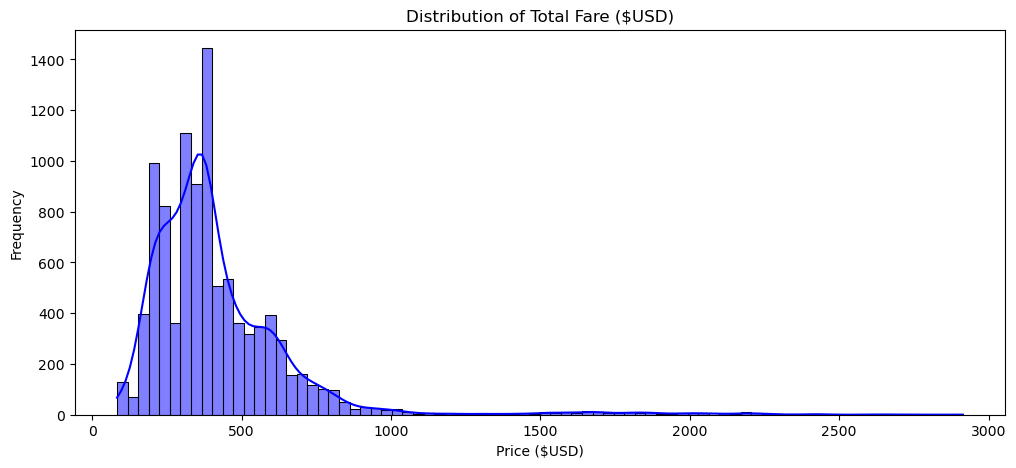

In [18]:
plt.figure(figsize=(12,5))
sns.histplot(df_pd, x="totalFare", bins=80, kde=True, color='blue', edgecolor='black')
plt.xlabel('Price ($USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Fare ($USD)')
plt.show()

We observe that the distribution peaks slightly under 500. Which is makes sense that this is the range of domestic prices 

In [19]:
quartile_values = [0.01, 0.10, 0.25, 0.5, 0.75, 0.90, 0.99]

# Use the approxQuantile function to get quartiles
quartiles = df.approxQuantile("totalFare", quartile_values, 0.01)

In [20]:
quartile_values

[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

In [21]:
pd.DataFrame({"quartile":quartile_values, "price":quartiles})

,quartile,price
0,0.01,82.61
1,0.10,207.60
2,0.25,261.61
3,0.50,368.60
4,0.75,488.60
5,0.90,639.60
6,0.99,2912.60


### Correlation with other variables

In [22]:
numerical_columns

['elapsedDays',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance']

In [23]:
vector_assembler = VectorAssembler(inputCols=["elapsedDays", "baseFare", "totalFare", "seatsRemaining"], outputCol="features")

In [24]:
df_num_ass = vector_assembler.transform(df)

In [25]:
correlation_matrix = Correlation.corr(df_num_ass, "features")
correlation_matrix = correlation_matrix.collect()[0]["pearson({})".format("features")].values.reshape(4,4)

24/03/16 16:38:00 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


<Axes: >

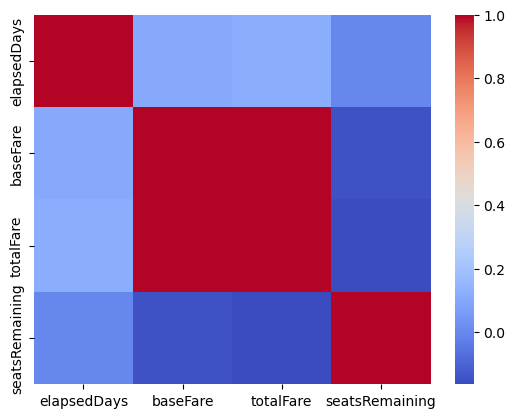

In [26]:
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", xticklabels=["elapsedDays", "baseFare", "totalFare", "seatsRemaining"], yticklabels=["elapsedDays", "baseFare", "totalFare", "seatsRemaining"])

## Flight Routes

We are now interested in the flight paths that are represented in the dataset. 

### Most Departed From Airports

In [27]:
depart_counts = df.groupBy("startingAirport").count()
sorted_depart_counts = depart_counts.orderBy(col("count").desc())
sorted_depart_counts.show()

+---------------+-----+
|startingAirport|count|
+---------------+-----+
|            CLT| 1215|
|            ATL| 1115|
|            LAX|  889|
|            BOS|  869|
|            SFO|  744|
|            ORD|  712|
|            DEN|  616|
|            DTW|  613|
|            PHL|  543|
|            DFW|  481|
|            LGA|  452|
|            EWR|  432|
|            IAD|  395|
|            MIA|  336|
|            OAK|  308|
|            JFK|  279|
+---------------+-----+



In [28]:
arrive_counts = df.groupBy("destinationAirport").count()
sorted_arrive_counts = arrive_counts.orderBy(col("count").desc())
sorted_arrive_counts.show()

+------------------+-----+
|destinationAirport|count|
+------------------+-----+
|               LAX|  956|
|               LGA|  946|
|               BOS|  766|
|               DEN|  728|
|               DFW|  728|
|               DTW|  687|
|               ATL|  669|
|               EWR|  661|
|               ORD|  611|
|               SFO|  604|
|               MIA|  574|
|               CLT|  517|
|               JFK|  500|
|               PHL|  436|
|               IAD|  364|
|               OAK|  252|
+------------------+-----+



### Pairs of Flight Paths

In [29]:
airport_counts = df.groupBy("startingAirport", "destinationAirport").count()
sorted_airport_counts = airport_counts.orderBy(col("count").desc())

In [30]:
# Total number of routes
print(f"The total number of routes represented in our data is {sorted_airport_counts.count()}")

The total number of routes represented in our data is 234


In [31]:
# Top routes taken
sorted_airport_counts.show(n=10)

+---------------+------------------+-----+
|startingAirport|destinationAirport|count|
+---------------+------------------+-----+
|            CLT|               LAX|  136|
|            ATL|               LAX|  133|
|            ATL|               DTW|  129|
|            CLT|               LGA|  129|
|            ATL|               LGA|  109|
|            CLT|               DEN|  106|
|            DEN|               BOS|  102|
|            BOS|               LAX|  101|
|            CLT|               ORD|   99|
|            CLT|               DFW|   99|
+---------------+------------------+-----+
only showing top 10 rows



In [32]:
# Least routes taken
sorted_airport_counts.tail(10)

[Row(startingAirport='OAK', destinationAirport='IAD', count=12),
 Row(startingAirport='DEN', destinationAirport='OAK', count=12),
 Row(startingAirport='LAX', destinationAirport='OAK', count=11),
 Row(startingAirport='IAD', destinationAirport='CLT', count=11),
 Row(startingAirport='PHL', destinationAirport='OAK', count=9),
 Row(startingAirport='JFK', destinationAirport='IAD', count=9),
 Row(startingAirport='DTW', destinationAirport='IAD', count=9),
 Row(startingAirport='JFK', destinationAirport='OAK', count=9),
 Row(startingAirport='MIA', destinationAirport='OAK', count=7),
 Row(startingAirport='OAK', destinationAirport='JFK', count=7)]

## 